In [13]:
import boto3
import os
from dotenv import load_dotenv

load_dotenv()
access_key_id = os.getenv("ACCESS_KEY_ID")
secret_access_key = os.getenv("SECRET_ACCESS_KEY")
minio_url = "http://" + os.getenv("S3_API_ENDPOINT")


minio_client = boto3.client(
    "s3",
    aws_access_key_id=access_key_id,
    aws_secret_access_key=secret_access_key,
    endpoint_url=minio_url
)

new_bucket = "trusted-zone"
try:
    minio_client.create_bucket(Bucket=new_bucket)
except (minio_client.exceptions.BucketAlreadyExists, minio_client.exceptions.BucketAlreadyOwnedByYou):
    print(f"Bucket '{new_bucket}' already exists")

Bucket 'trusted-zone' already exists


Defines the `analyze_audio_file()` function that performs comprehensive quality analysis on audio files. It filter type detection (low-pass, high-pass, band-pass).


In [14]:
def detectar_filtro(centroid, rolloff, ratio):
    if centroid < 1500 and rolloff < 3000 and ratio < 0.5:
        return "Low-pass filter"
    elif centroid > 4000 and rolloff > 6000 and ratio > 1.5:
        return "High-pass filter"
    elif 1500 <= centroid <= 4000 and 3000 <= rolloff <= 6000 and 0.5 <= ratio <= 1.5:
        return "Band-pass filter"
    else:
        return "No filter"

## Audio Quality Analysis

This notebook analyzes audio quality metrics in the dataset. Each metric provides insights into audio characteristics that could affect processing and embedding generation.


In [15]:
# DO THE ANALYSIS OF ALL THE AUDIO FILES.
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
import math
import pandas as pd
from pydub import AudioSegment
from pydub.silence import detect_silence

def analyze_audio_file(audio_bytes):
    """
    This function analyzes all audio files in the Formatted Zone and stores the results in a JSON file.
    """
    # Get all audio files from the Formatted Zone
    
    audio = AudioSegment.from_file(BytesIO(audio_bytes))
    
    # ---- BASIC INFORMATION ----
    
    duration = len(audio) / 1000        # DURATION IN SECONDS.
    frame_rate = audio.frame_rate       # SAMPLING FREQUENCY.
    channels = audio.channels           # CHANNELS.
    sample_width = audio.sample_width   # SAMPLING WIDTH IN BYTES. IF WE WANT IT IN BITS MULTIPLY BY 8.
    
    # ---- SOUND & VOLUME INFORMATION ----
    
    rms = audio.rms
    audio_level = 20 * math.log10(rms) if rms > 0 else -float('inf')    #RMS CONVERSION TO DECIBELS.
    peak = audio.max                                                    # PEAK VOLUME.
    noise_floor = audio.dBFS                                            # NOISE FLOOR.
    
    # ---- DETECT SILENCE ----
    
    silence_ranges = detect_silence(audio, min_silence_len=500, silence_thresh=-50)     # DETECT SILENCES.
    total_silence_duration = sum(end - start for start, end in silence_ranges) / 1000   # CONVERT TO SECONDS.
    silence_percent = (total_silence_duration / duration) * 100 if duration > 0 else 0  # PERCENTAGE OF SILENCE.
    
    # ---- DYNAMIC RANGE ----
    dynamic_range = peak - rms
    
    # ---- HIGH-PASS & LOW-PASS FILTERS ----
    
    "This section analyzes an audio file to determine whether it has a low-pass, high-pass, or band-pass filter applied."
    "It converts the audio into numerical data, measures how the energy is distributed across low and high"
    "frequencies, and based on that distribution, classifies the type of filter that appears to be present."
    
    samples = np.array(audio.get_array_of_samples()).astype(np.float32)                 # GET SAMPLES.

    if channels == 2:                                                                   # IF CHANEL IS ESTEREO WE CONVERT TO MONO.
        samples = samples.reshape((-1, 2))
        samples = np.mean(samples, axis=1)
        
    samples /= np.iinfo(audio.array_type).max                                          # NORMALIZE SAMPLES.
    sr = audio.frame_rate                                                               # GET SAMPLING RATE.
    
    
    centroid = librosa.feature.spectral_centroid(y=samples, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=samples, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=samples, sr=sr, roll_percent=0.95)

    S = np.abs(librosa.stft(samples))
    freqs = librosa.fft_frequencies(sr=sr)

    low_energy = np.sum(S[(freqs > 0) & (freqs < 1000)])
    high_energy = np.sum(S[freqs > 5000])
    ratio = high_energy / (low_energy + 1e-9)

    # GLOBAL AVERAGES
    centroid_mean = np.mean(centroid)
    bandwidth_mean = np.mean(bandwidth)
    rolloff_mean = np.mean(rolloff)
    
    # FILTER DETECTION
    filter_type = detectar_filtro(centroid_mean, rolloff_mean, ratio)
    
    return {
        "duration": duration,
        "frame_rate": frame_rate,
        "channels": channels,
        "sample_width": sample_width,
        "audio_level": audio_level,
        "peak": peak,
        "noise_floor": noise_floor,
        "silence_ranges": silence_ranges,
        "total_silence_duration": total_silence_duration,
        "silence_percent": silence_percent,
        "dynamic_range": dynamic_range,
        "filter_type": filter_type
    }

In [12]:
from tqdm import tqdm
analysis_results = []
bucket_origen = "formatted-zone"
prefix_origen = "audio/"

paginator = minio_client.get_paginator("list_objects_v2")

for page in paginator.paginate(Bucket=bucket_origen, Prefix=prefix_origen):
    for obj in tqdm(page.get("Contents", []), desc="Processant àudios"):
        key = obj["Key"]
        filename = key.split("/")[-1]

        #Read original audio
        response = minio_client.get_object(Bucket=bucket_origen, Key=key)
        audio_data = response["Body"].read()
        analysis_results.append(analyze_audio_file(audio_data))
        
df = pd.DataFrame(analysis_results)
df.head()

Processant àudios: 100%|██████████| 100/100 [00:16<00:00,  6.08it/s]


,duration,frame_rate,channels,sample_width,audio_level,peak,noise_floor,silence_ranges,total_silence_duration,silence_percent,dynamic_range,filter_type
0,1.382,22050,1,2,76.702392,31330,-13.606607,[],0.0,0.0,24489,No filter
1,3.611,22050,1,2,73.131546,32156,-17.177453,[],0.0,0.0,27621,No filter
2,5.236,22050,1,2,72.831465,32444,-17.477534,[],0.0,0.0,28063,No filter
3,3.576,22050,1,2,71.487571,31279,-18.821427,[],0.0,0.0,27526,No filter
4,2.067,22050,1,2,74.234458,31085,-16.074541,[],0.0,0.0,25936,No filter


## Audio Quality Metrics Description

**analisi_audio()**: This function analyzes audio files using librosa and pydub libraries to extract quality metrics:

### **Basic Audio Properties**
- **`duration`**: Length of audio in seconds. Important for batch processing consistency
- **`frame_rate`**: Sampling frequency (Hz). Higher rates (>44.1 kHz) provide better quality
- **`channels`**: Number of audio channels (1=mono, 2=stereo). Affects file size and processing
- **`sample_width`**: Bit depth in bytes (1=8-bit, 2=16-bit). Higher values mean better quality

### **Volume and Energy**
- **`audio_level`**: RMS (Root Mean Square) converted to decibels. Represents average volume
  - Too quiet: < -20 dB
  - Ideal range: -12 to -18 dB
  - Too loud: > -5 dB (risks clipping)
- **`peak`**: Maximum volume level. High peaks may indicate clipping
- **`noise_floor`**: Background noise level in dBFS. Lower values (<-60 dBFS) indicate cleaner audio

### **Audio Dynamics**
- **`dynamic_range`**: Difference between peak and average volume. Higher values indicate natural audio with good volume variations
- **`silence_percent`**: Percentage of silence in audio. High values (>30%) may indicate poor recordings

### **Spectral Analysis**
- **`filter_type`**: Detects if audio has low-pass, high-pass, or band-pass filters applied
  - "No filter": Natural, unfiltered audio (preferred)
  - "Low-pass filter": May indicate degraded high-frequency content
  - "High-pass filter": May indicate noise removal or low-frequency cuts


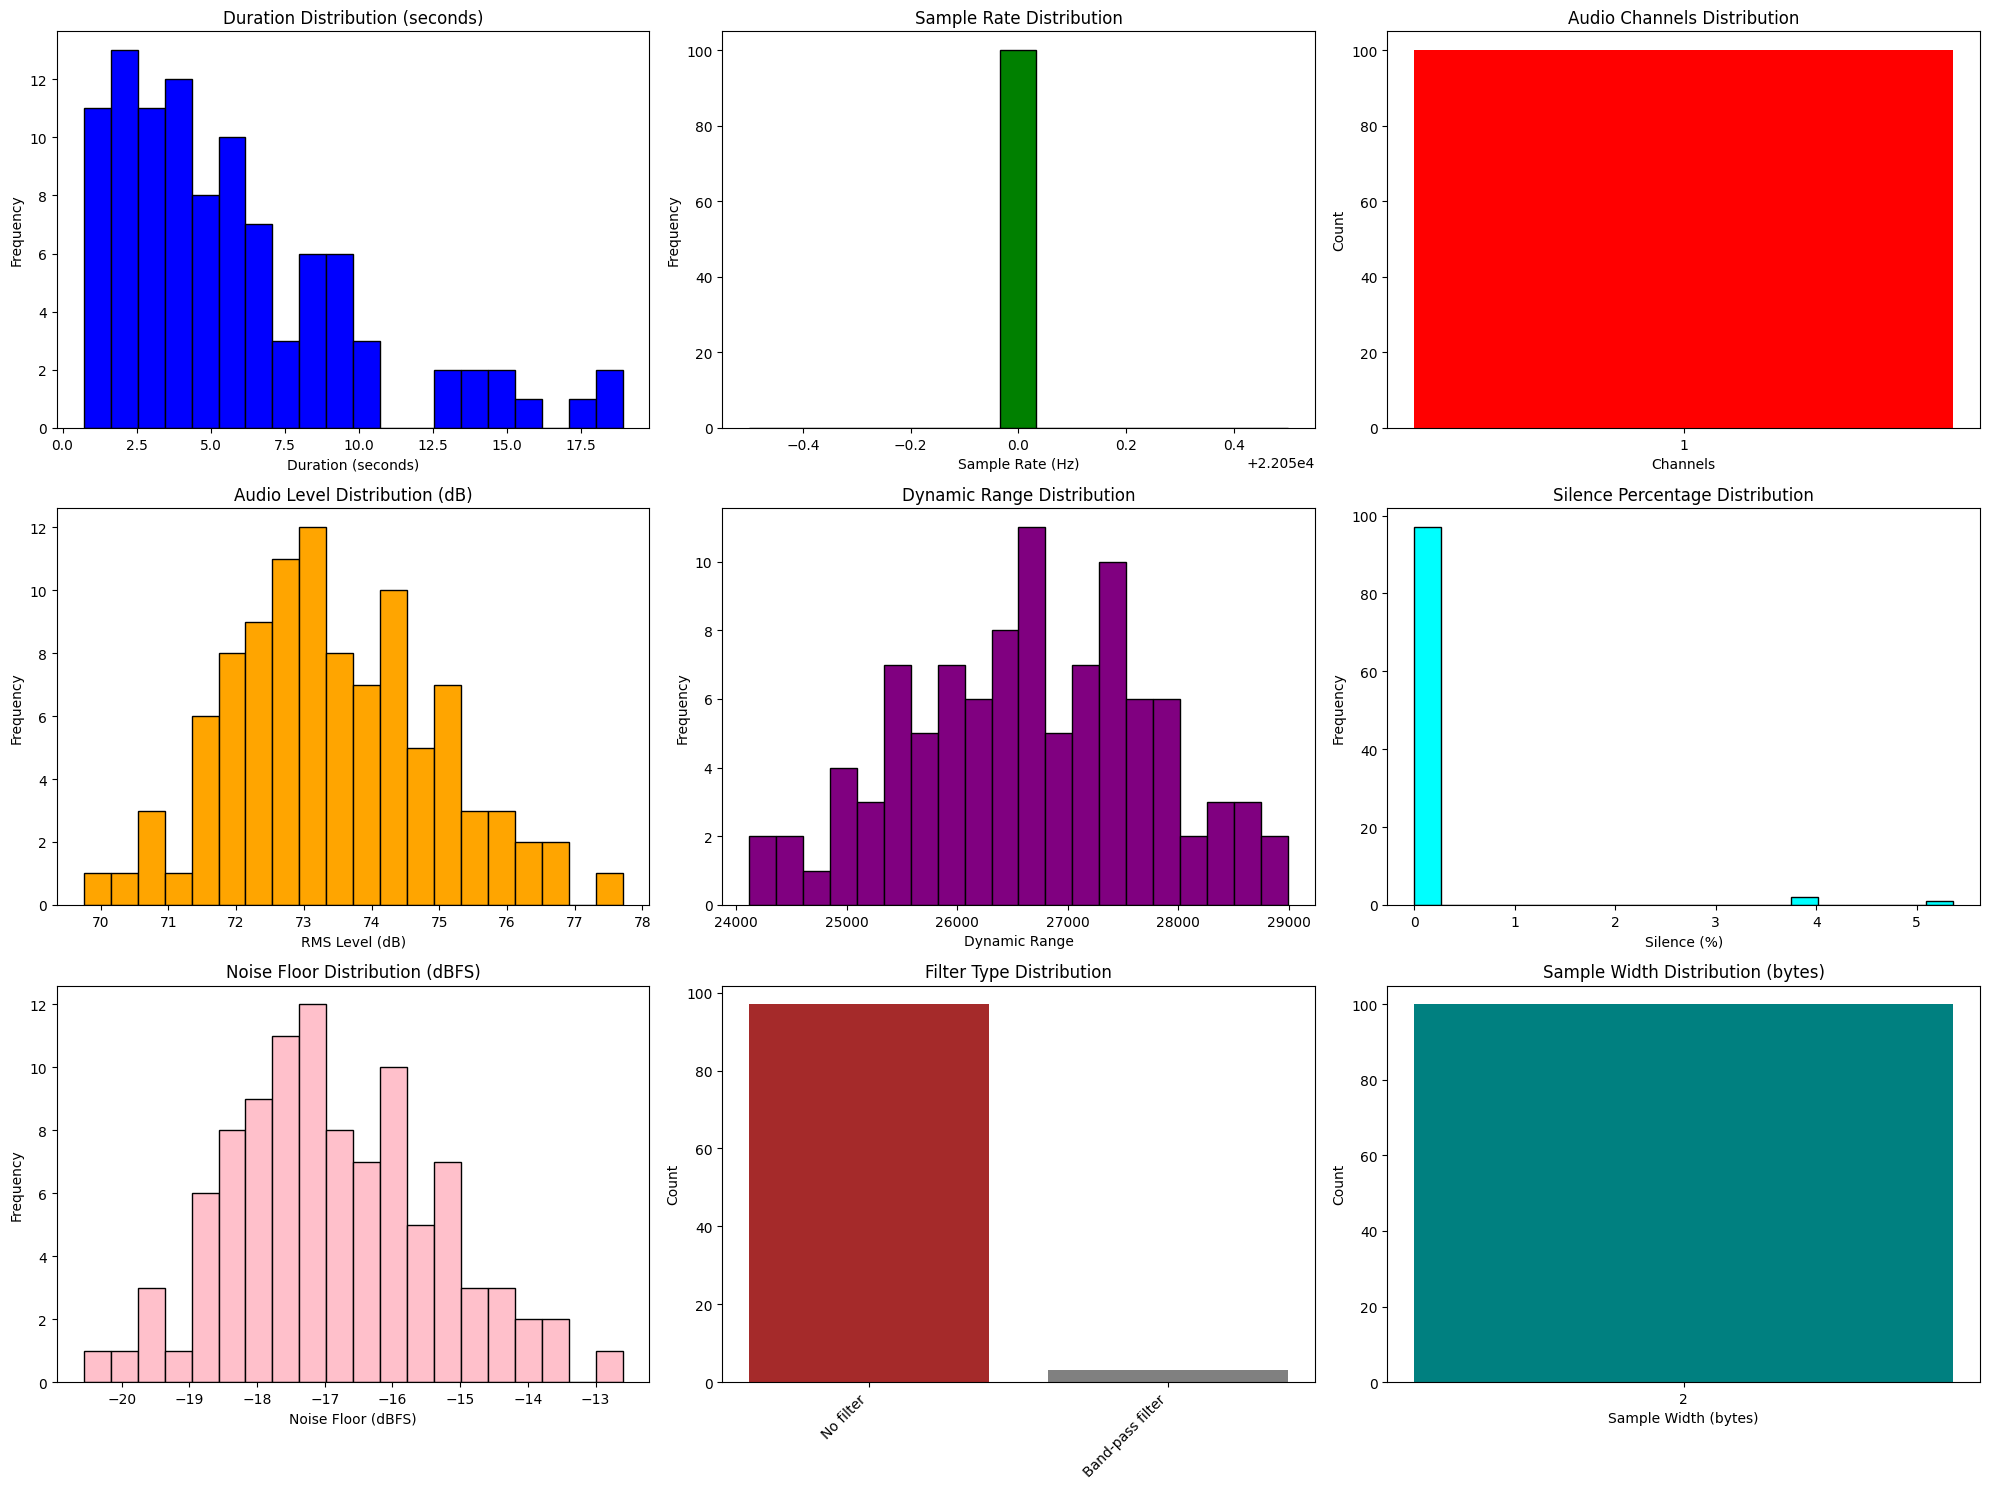

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# AUDIO QUALITY VISUALIZATION
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# 1. Duration distribution
axes[0, 0].hist(df['duration'], bins=20, color='blue', edgecolor='black')
axes[0, 0].set_title('Duration Distribution (seconds)')
axes[0, 0].set_xlabel('Duration (seconds)')
axes[0, 0].set_ylabel('Frequency')

# 2. Frame rate (sample rate) distribution
axes[0, 1].hist(df['frame_rate'], bins=15, color='green', edgecolor='black')
axes[0, 1].set_title('Sample Rate Distribution')
axes[0, 1].set_xlabel('Sample Rate (Hz)')
axes[0, 1].set_ylabel('Frequency')

# 3. Channels (mono vs stereo)
channels_counts = df['channels'].value_counts()
axes[0, 2].bar(channels_counts.index.astype(str), channels_counts.values, color=['red', 'blue'])
axes[0, 2].set_title('Audio Channels Distribution')
axes[0, 2].set_xlabel('Channels')
axes[0, 2].set_ylabel('Count')

# 4. Audio level (RMS in dB)
axes[1, 0].hist(df['audio_level'], bins=20, color='orange', edgecolor='black')
axes[1, 0].set_title('Audio Level Distribution (dB)')
axes[1, 0].set_xlabel('RMS Level (dB)')
axes[1, 0].set_ylabel('Frequency')

# 5. Dynamic range
axes[1, 1].hist(df['dynamic_range'], bins=20, color='purple', edgecolor='black')
axes[1, 1].set_title('Dynamic Range Distribution')
axes[1, 1].set_xlabel('Dynamic Range')
axes[1, 1].set_ylabel('Frequency')

# 6. Silence percentage
axes[1, 2].hist(df['silence_percent'], bins=20, color='cyan', edgecolor='black')
axes[1, 2].set_title('Silence Percentage Distribution')
axes[1, 2].set_xlabel('Silence (%)')
axes[1, 2].set_ylabel('Frequency')

# 7. Noise floor (dBFS)
axes[2, 0].hist(df['noise_floor'], bins=20, color='pink', edgecolor='black')
axes[2, 0].set_title('Noise Floor Distribution (dBFS)')
axes[2, 0].set_xlabel('Noise Floor (dBFS)')
axes[2, 0].set_ylabel('Frequency')

# 8. Filter type distribution
filter_counts = df['filter_type'].value_counts()
axes[2, 1].bar(range(len(filter_counts)), filter_counts.values, color=['brown', 'gray', 'gold', 'coral'])
axes[2, 1].set_title('Filter Type Distribution')
axes[2, 1].set_xticks(range(len(filter_counts)))
axes[2, 1].set_xticklabels(filter_counts.index, rotation=45, ha='right')
axes[2, 1].set_ylabel('Count')

# 9. Sample width distribution
sample_width_counts = df['sample_width'].value_counts()
axes[2, 2].bar(sample_width_counts.index.astype(str), sample_width_counts.values, color='teal')
axes[2, 2].set_title('Sample Width Distribution (bytes)')
axes[2, 2].set_xlabel('Sample Width (bytes)')
axes[2, 2].set_ylabel('Count')

plt.tight_layout()
plt.show()


A comprehensive 3x3 grid of visualizations showing all detected audio quality metrics. It displays distributions for numerical metrics (duration, sample rate, audio level, dynamic range, silence, noise floor) and bar charts for categorical metrics (channels, filter types, sample width).


### **Interpretation of the Audio Visualizations**

Each chart provides insights into different audio quality aspects:

1. **Duration Distribution**: Shows how long audio files are. Concentrated peaks indicate consistent file lengths, good for batch processing. Widely scattered durations suggest diverse content that may need normalization.

2. **Sample Rate Distribution**: The frame rate (samples per second) determines audio fidelity. Higher sample rates (>44.1 kHz) indicate high-quality recordings. A single peak means all files have the same sample rate, ideal for consistency.

3. **Channels Distribution**: Shows whether audio is mono (1 channel) or stereo (2 channels). Consistent channel configuration ensures uniform processing.

4. **Audio Level (RMS in dB)**: Represents the average volume level. Values below -20 dB may be too quiet, while values above -5 dB may cause clipping. A concentration around -12 to -18 dB is typically ideal.

5. **Dynamic Range**: The difference between peak and average volume. Higher dynamic range indicates better audio quality with natural volume variations. Low dynamic range suggests over-compression.

6. **Silence Percentage**: The amount of silence in audio files. High percentages (>30%) may indicate recordings with excessive pauses or poor quality. Normal speech audio typically has 5-15% silence.

7. **Noise Floor (dBFS)**: The level of background noise. Values above -60 dBFS indicate significant noise. Lower values (below -60 dBFS) suggest cleaner audio recordings.

8. **Filter Type Distribution**: Detects if audio has frequency filters applied. "No filter" is typically desired for natural audio. Low-pass filters might indicate degraded quality, while high-pass filters could suggest noise removal.

9. **Sample Width Distribution**: The bit depth of audio samples. Higher values (2 bytes = 16-bit) provide better quality than lower values (1 byte = 8-bit).

**What to Look For**:
- Consistent sample rates and channels for uniform processing
- Audio levels concentrated in the -12 to -18 dB range for optimal volume
- Low silence percentages (<20%) for most audio types
- Noise floor below -60 dBFS for clean recordings
- "No filter" in filter type distribution for natural audio
- 2-byte sample width for good quality

**Potential Quality Issues**:
- Very short or very long durations may need normalization
- Low sample rates (<16 kHz) may reduce audio quality
- High silence percentage (>30%) suggests poor recordings
- High noise floor (>-50 dBFS) indicates noisy audio
- Non-uniform filter types may require preprocessing


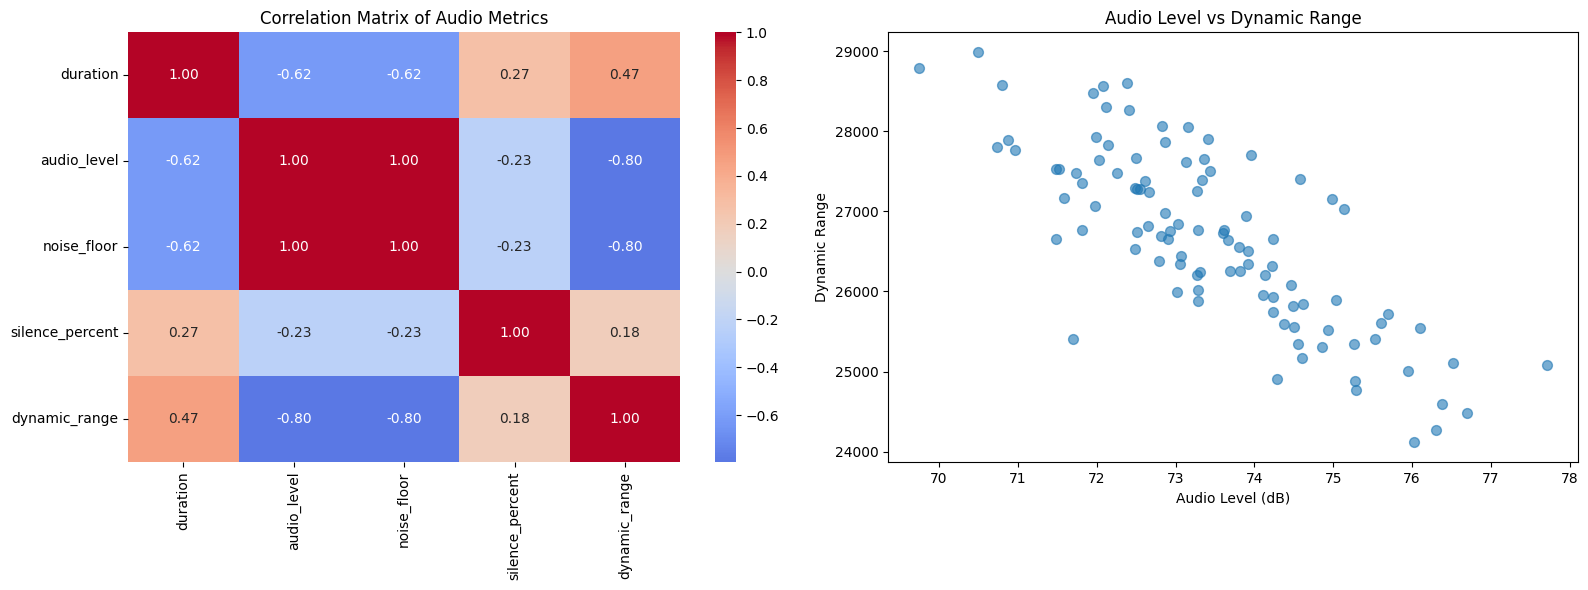

In [8]:
# CORRELATION ANALYSIS
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Correlation matrix
correlation_metrics = ['duration', 'audio_level', 'noise_floor', 'silence_percent', 'dynamic_range']
corr_matrix = df[correlation_metrics].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Correlation Matrix of Audio Metrics')

# Audio level vs Dynamic range
axes[1].scatter(df['audio_level'], df['dynamic_range'], alpha=0.6, s=50)
axes[1].set_title('Audio Level vs Dynamic Range')
axes[1].set_xlabel('Audio Level (dB)')
axes[1].set_ylabel('Dynamic Range')

plt.tight_layout()
plt.show()


### **What This Correlation Analysis Shows**

**Correlation Matrix**: This heatmap identifies relationships between different audio metrics:
- **Positive correlations (red)**: Two metrics increase or decrease together. For example, if audio_level and dynamic_range are positively correlated, louder audio tends to have more dynamic range.
- **Negative correlations (blue)**: One metric increases while the other decreases. For instance, if silence_percent and audio_level are negatively correlated, files with less silence tend to have higher audio levels.
- **Near-zero correlations**: Metrics are independent. This helps identify which quality aspects are unrelated.

**Audio Level vs Dynamic Range Scatter Plot**: This visualization reveals patterns between volume and audio quality:
- **Cloud pattern**: Shows natural variation in the dataset
- **Positive trend**: Increasing audio level associated with increasing dynamic range indicates good quality recordings
- **Negative trend or clustering**: May indicate compression artifacts or quality issues
- **Outliers**: Points far from the main cloud may represent problematic recordings that need attention

**Why This Matters**: Understanding metric relationships helps prioritize which quality improvements will have the most impact and identify potential systemic issues in the audio processing pipeline.


In [9]:
# STATISTICAL SUMMARY
print("="*80)
print("Audio Quality Analysis - Summary Statistics")
print("="*80 + "\n")

print(f"Total audio files analyzed: {len(df)}\n")

print("DURATION:")
print(f"   Average duration: {df['duration'].mean():.2f} seconds")
print(f"   Minimum duration: {df['duration'].min():.2f} seconds")
print(f"   Maximum duration: {df['duration'].max():.2f} seconds\n")

print("SAMPLE RATE:")
print(f"   Average sample rate: {df['frame_rate'].mean():.0f} Hz")
print(f"   Most common sample rate: {df['frame_rate'].mode()[0]:.0f} Hz\n")

print("CHANNELS:")
for channel in sorted(df['channels'].unique()):
    count = (df['channels'] == channel).sum()
    print(f"   {channel} channel(s): {count} files ({(count/len(df)*100):.1f}%)\n")

print("AUDIO LEVEL (RMS):")
print(f"   Average level: {df['audio_level'].mean():.1f} dB")
print(f"   Minimum level: {df['audio_level'].min():.1f} dB")
print(f"   Maximum level: {df['audio_level'].max():.1f} dB\n")

print("DYNAMIC RANGE:")
print(f"   Average dynamic range: {df['dynamic_range'].mean():.1f}")
print(f"   Files with low dynamic range (<1000): {(df['dynamic_range'] < 1000).sum()}\n")

print("SILENCE:")
print(f"   Average silence: {df['silence_percent'].mean():.1f}%")
print(f"   Files with high silence (>30%): {(df['silence_percent'] > 30).sum()}\n")

print("NOISE FLOOR:")
print(f"   Average noise floor: {df['noise_floor'].mean():.1f} dBFS")
print(f"   Files with high noise floor (>-50 dBFS): {(df['noise_floor'] > -50).sum()}\n")

print("FILTER TYPES:")
for filter_type in sorted(df['filter_type'].unique()):
    count = (df['filter_type'] == filter_type).sum()
    print(f"   {filter_type}: {count} files ({(count/len(df)*100):.1f}%)")

print("="*80)


Audio Quality Analysis - Summary Statistics

Total audio files analyzed: 100

DURATION:
   Average duration: 5.75 seconds
   Minimum duration: 0.72 seconds
   Maximum duration: 18.90 seconds

SAMPLE RATE:
   Average sample rate: 22050 Hz
   Most common sample rate: 22050 Hz

CHANNELS:
   1 channel(s): 100 files (100.0%)

AUDIO LEVEL (RMS):
   Average level: 73.5 dB
   Minimum level: 69.8 dB
   Maximum level: 77.7 dB

DYNAMIC RANGE:
   Average dynamic range: 26657.3
   Files with low dynamic range (<1000): 0

SILENCE:
   Average silence: 0.1%
   Files with high silence (>30%): 0

NOISE FLOOR:
   Average noise floor: -16.9 dBFS
   Files with high noise floor (>-50 dBFS): 100

FILTER TYPES:
   Band-pass filter: 3 files (3.0%)
   No filter: 97 files (97.0%)


--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------